In [8]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat, umath, unumpy
from math import log10, floor

In [9]:
# Settings + Notes
"""The units used are in SI units."""

# Plotting Settings
plt.style.use("default")

# # remove interactive mode
# plt.ioff()

# # disable images from automatically showing up
# use("Agg")

# Exporting Saved Images
def export_plot(plot, filename, savelocation="../exports/", _quality=95, _dpi=100, _optimize=True):
    """Saves a plot to the specified location."""
    plot.savefig(str(savelocation + filename), quality=_quality, dpi=_dpi, optimize=_optimize)

# Importan

In [10]:
# Constants
G = ufloat(9.81, 0.03)  # the gravitational acceleration measured at UofT MP: https://faraday.physics.utoronto.ca/PVB/Harrison/ErrorAnalysis/Introduction.html

UNCERTAINTY_CALIPER = ufloat(0, 0)  # m
UNCERTAINTY_TIME = ufloat(0, 0) # s

In [11]:
# Equations
def mean(array):
    return sum(array)/len(array)

def standard_deviation(array):
    numerator = 0
    arrayMean = mean(array)
    N = len(array)
    for i in range(N):
        numerator += umath.pow((array[i] - arrayMean), 2)
    return umath.pow((numerator/N), 1/2)

def convert_to_ufloat(data, uncert):
    if not isinstance(data, (list, tuple, set)):
        return ufloat(data, uncert)
    return [ufloat(e, uncert) for e in data]

def seperate_ufloat(data):
    if not isinstance(data, (list, tuple, set)):
        return data.nominal_value, data.std_dev
    nominals, devs = [], []
    for e in data:
        nominals.append(e.nominal_value)
        devs.append(e.std_dev)
    return nominals, devs

def chi_squared(dataX, dataY, f):
    chi2 = 0
    for i in range(len(dataX)):
        collected = dataY[i]
        actual = f(dataX[i])
        chi2 = (umath.pow(actual - collected, 2))/actual
    return chi2

def coeff_of_determination(dataX, dataY, func):
    N = len(dataX)
    yBar = mean(dataY)
    SS_tot = [umath.pow((e - yBar), 2) for e in dataY]
    SS_reg = [umath.pow((func(dataX[i]) - yBar), 2) for i in range(N)]
    SS_res = [umath.pow((dataY[i] - func(dataX[i])), 2) for i in range(N)]
    return 1 - sum(SS_res)/sum(SS_tot)

def round_sig(x, sig=1):
    return round(x, sig-int(floor(log10(abs(x))))-1)

def volume_sphere(R):
    return (4/3) * np.pi * pow(R, 3)

def calculate_tau(m, r, eta):
    return m/(6 * np.pi * r * eta)

def reynolds_number(rho, l, v, eta):
    return rho * l * v/eta

In [12]:
# Numerical Exercise
# givens
r = 0.5 * pow(10, -3)  # m 
n = 1500 * pow(10, -2)  # Poise
p = 2.7 # g/cm^3



tau = calculate_tau()



print("Tau is: {}[s]".format(tau))

Tau is: 0[s]


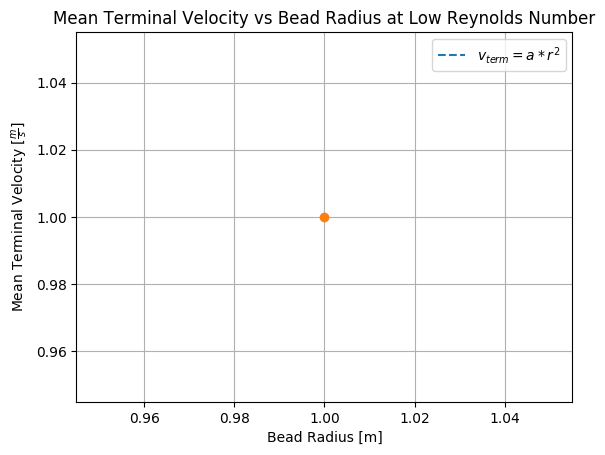

In [13]:
# Ex.1: Low Reynolds Number
# data


# fitting


# plotting
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True)
ax.set_title("Mean Terminal Velocity vs Bead Radius at Low Reynolds Number")
ax.set_xlabel("Bead Radius [m]")
ax.set_ylabel("Mean Terminal Velocity $[\\frac{m}{s}]$")

ax.plot([1], [1], "--")  # quadratic fit
ax.plot([1], [1], "o")

ax.legend(["$v_{term} = a*r^2$"])

export_plot(fig, "ex1_mean_vterm_n_beadr")


# Note
- 

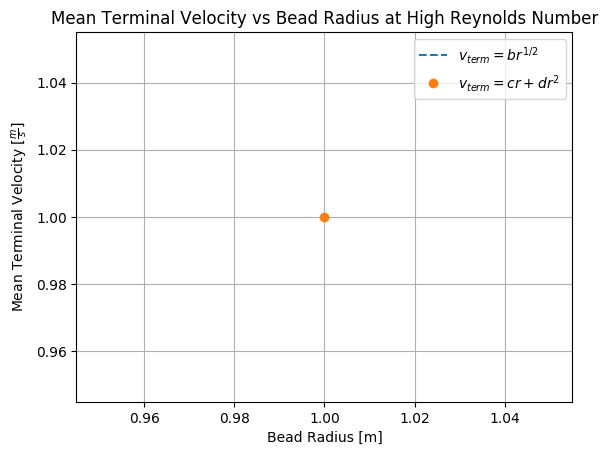

In [14]:
# Ex.2: High Reynolds Number
# data


# fitting


# plotting
fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(True)
ax.set_title("Mean Terminal Velocity vs Bead Radius at High Reynolds Number")
ax.set_xlabel("Bead Radius [m]")
ax.set_ylabel("Mean Terminal Velocity $[\\frac{m}{s}]$")

ax.plot([1], [1], "--")  # radical fit
ax.plot([1], [1], "o")

ax.legend(["$v_{term} = br^{1/2}$", "$v_{term} = cr + dr^2$"])

export_plot(fig, "ex2_mean_vterm_n_beadr")